# `CNModel` Tutorial

Trey V. Wenger (c) March 2025

Here we demonstrate the basic features of the `CNModel` model. The `CNModel` models the hyperfine spectral structure of ${\rm CN}$ and $^{13}{\rm CN}$ including non-LTE effects. Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("arviz version:", az.__version__)

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

arviz version: 0.22.0dev
pymc version: 5.21.1
bayes_spec version: 1.7.4
bayes_cn_hfs version: 1.1.1+6.g94944ab.dirty


## `supplement_mol_data`

Here we model the hyperfine structure of CN emission. We use the helper function `supplement_mol_data` to download the molecular data for this molecule.

In [2]:
from bayes_cn_hfs import supplement_mol_data

mol_data_12CN, mol_weight_12CN = supplement_mol_data("CN")
print(mol_data_12CN.keys())
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Upper state degrees of freedom:", mol_data_12CN['degu'])
print("Lower state energy level (erg)", mol_data_12CN['El'])
print("Upper state energy level (erg)", mol_data_12CN['Eu'])
print("Relative intensities", mol_data_12CN['relative_int'])
print("Partition function terms:", mol_data_12CN["log10_Q_terms"])
print("Upper state quantum numbers:", mol_data_12CN["Qu"])
print("lower states quantum numbers", mol_data_12CN["Ql"])
print("state info", mol_data_12CN["states"])

dict_keys(['freq', 'Aul', 'degu', 'El', 'Eu', 'relative_int', 'log10_Q_terms', 'Qu', 'Ql', 'states', 'state_u_idx', 'state_l_idx', 'Gu', 'Gl'])
transition frequency (MHz): [113123.3687 113144.19   113170.535  113191.325  113488.142  113490.985
 113499.643  113508.934  113520.4215]
Einstein A coefficient (s-1): [1.26969616e-06 1.03939111e-05 5.07869910e-06 6.59525390e-06
 6.64784064e-06 1.17706070e-05 1.04919208e-05 5.12459350e-06
 1.28243028e-06]
Upper state degrees of freedom: [2 2 4 4 4 6 2 4 2]
Lower state energy level (erg) [1.3905121e-19 0.0000000e+00 1.3905121e-19 0.0000000e+00 1.3905121e-19
 0.0000000e+00 1.3905121e-19 0.0000000e+00 0.0000000e+00]
Upper state energy level (erg) [7.49702428e-16 7.49701340e-16 7.50014955e-16 7.50013660e-16
 7.52119441e-16 7.51999228e-16 7.52195648e-16 7.52118159e-16
 7.52194276e-16]
Relative intensities [0.01204699 0.09860036 0.09633376 0.1250773  0.12574146 0.33394774
 0.09921527 0.09691221 0.01212491]
Partition function terms: [0.40307694 0.9743

## Simulating Data

To test the model, we must simulate some data. We can do this with `CNModel`, but we must pack a "dummy" data structure first.

12CN-1 550
12CN-2 300


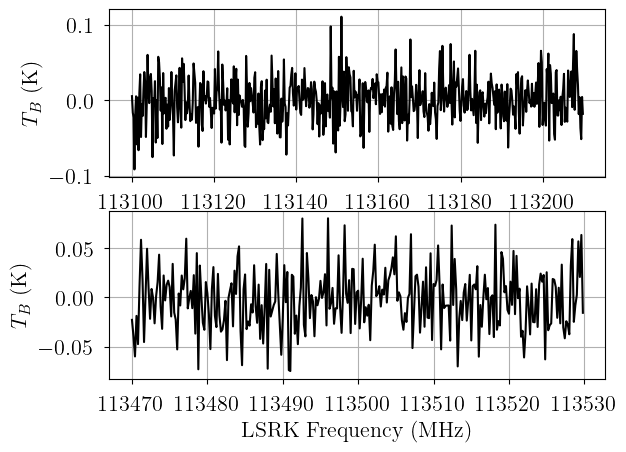

In [3]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis_1 = np.arange(113100.0, 113210.0, 0.2) # MHz
freq_axis_2 = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_1 = noise * np.random.randn(len(freq_axis_1)) # K
brightness_data_2 = noise * np.random.randn(len(freq_axis_2)) # K

# CNModel datasets can be named anything, here we name them "12CN-1" and "12CN-2"
obs_1 = SpecData(
    freq_axis_1,
    brightness_data_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    brightness_data_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
dummy_data = {"12CN-1": obs_1, "12CN-2": obs_2}

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, dummy_data["12CN-1"].brightness, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, dummy_data["12CN-2"].brightness, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the model for a given set of parameters.

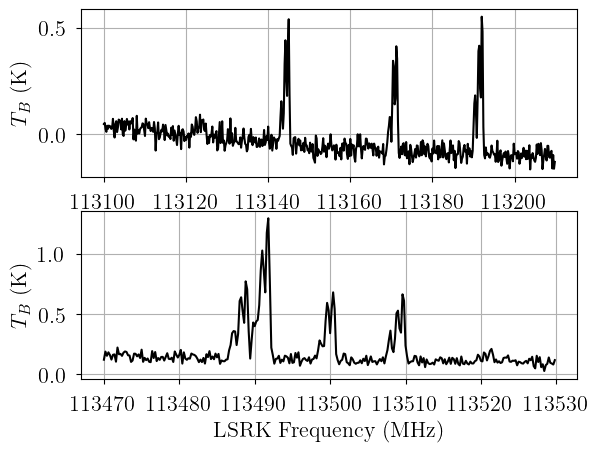

In [4]:
from bayes_cn_hfs.cn_model import CNModel

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 2 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 1.0], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX = True, # assume CTEX
    prior_LTE_precision = None, # ignored for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N": [13.8, 13.9, 14.0],
    "log10_Tkin": [0.65, 0.6, 0.5],
    "fwhm_nonthermal": [1.0, 1.25, 1.5],
    "velocity": [-2.0, 0.0, 2.5],
    "fwhm_L": 0.0,
    "baseline_12CN-1_norm": [-2.0, -5.0, 8.0],
    "baseline_12CN-2_norm": [4.0, -2.0, 5.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_obs1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_obs2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, sim_obs1, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, sim_obs2, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

In [5]:
sim_params

{'log10_N': [13.8, 13.9, 14.0],
 'log10_Tkin': [0.65, 0.6, 0.5],
 'fwhm_nonthermal': [1.0, 1.25, 1.5],
 'velocity': [-2.0, 0.0, 2.5],
 'fwhm_L': 0.0,
 'baseline_12CN-1_norm': [-2.0, -5.0, 8.0],
 'baseline_12CN-2_norm': [4.0, -2.0, 5.0],
 'fwhm_thermal': array([0.08867757, 0.08371703, 0.07461288]),
 'fwhm': array([1.00392416, 1.25280028, 1.50185455]),
 'log10_Tex_ul': array([0.65, 0.6 , 0.5 ]),
 'Tex': array([[4.46683592, 3.98107171, 3.16227766],
        [4.46683592, 3.98107171, 3.16227766],
        [4.46683592, 3.98107171, 3.16227766],
        [4.46683592, 3.98107171, 3.16227766],
        [4.46683592, 3.98107171, 3.16227766],
        [4.46683592, 3.98107171, 3.16227766],
        [4.46683592, 3.98107171, 3.16227766],
        [4.46683592, 3.98107171, 3.16227766],
        [4.46683592, 3.98107171, 3.16227766]]),
 'tau': array([[0.02780937, 0.03961643, 0.06312223],
        [0.22764058, 0.32429648, 0.51673788],
        [0.2223333 , 0.31672379, 0.5046276 ],
        [0.28871089, 0.41128963, 0.

In [7]:
# Now we pack the simulated spectrum into a new SpecData instance
obs_1 = SpecData(
    freq_axis_1,
    sim_obs1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    sim_obs2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
data = {"12CN-1": obs_1, "12CN-2": obs_2}

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `CNModel`. Here we create a new model with the simulated data.

In [8]:
# Initialize and define the model
model = CNModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 1.0], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX = True, # assume CTEX
    prior_LTE_precision = None, # ignored for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

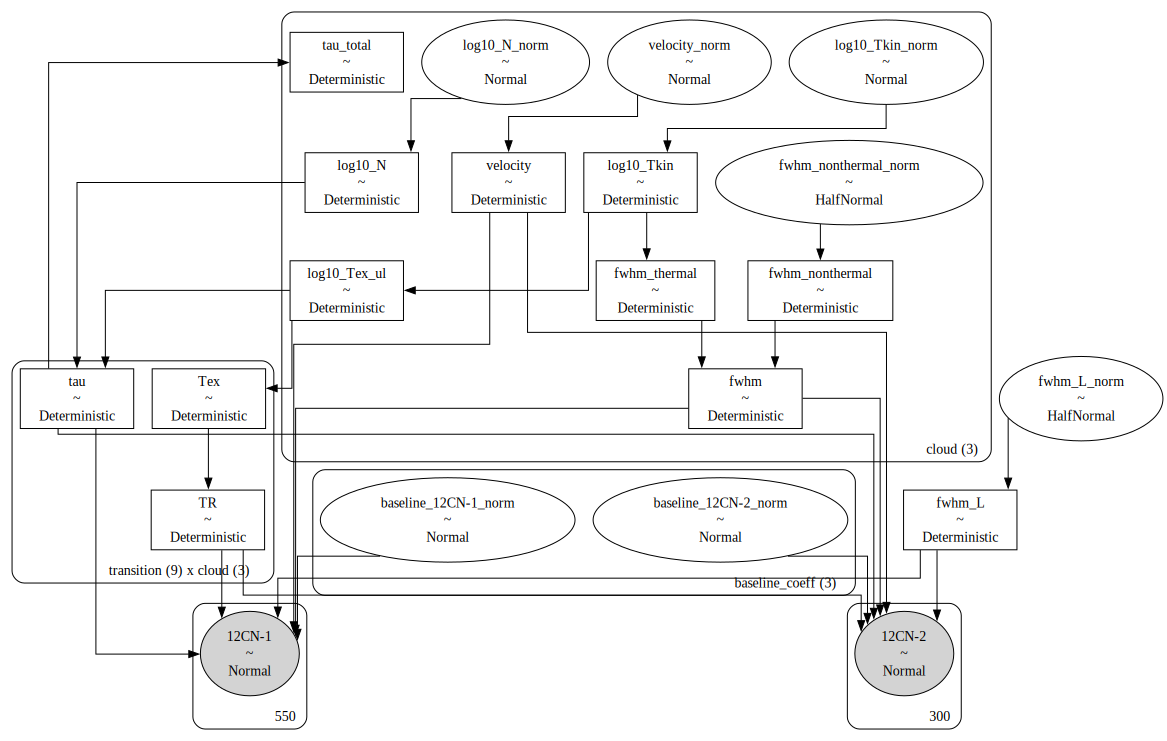

In [9]:
# Plot model graph
model.graph().render('cn_model', format='png')
model.graph()

In [10]:
# model string representation
print(model.model.str_repr())

baseline_12CN-1_norm ~ Normal(0, <constant>)
baseline_12CN-2_norm ~ Normal(0, <constant>)
       velocity_norm ~ Normal(0, 1)
     log10_Tkin_norm ~ Normal(0, 1)
fwhm_nonthermal_norm ~ HalfNormal(0, 1)
         fwhm_L_norm ~ HalfNormal(0, 1)
        log10_N_norm ~ Normal(0, 1)
            velocity ~ Deterministic(f(velocity_norm))
          log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
        fwhm_thermal ~ Deterministic(f(log10_Tkin_norm))
     fwhm_nonthermal ~ Deterministic(f(fwhm_nonthermal_norm))
                fwhm ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
              fwhm_L ~ Deterministic(f(fwhm_L_norm))
             log10_N ~ Deterministic(f(log10_N_norm))
        log10_Tex_ul ~ Deterministic(f(log10_Tkin_norm))
                 Tex ~ Deterministic(f(log10_Tkin_norm))
                 tau ~ Deterministic(f(log10_N_norm, log10_Tkin_norm))
           tau_total ~ Deterministic(f(log10_N_norm, log10_Tkin_norm))
                  TR ~ Deterministic(f(log10_Tkin

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [12CN-1, 12CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tkin_norm, velocity_norm]


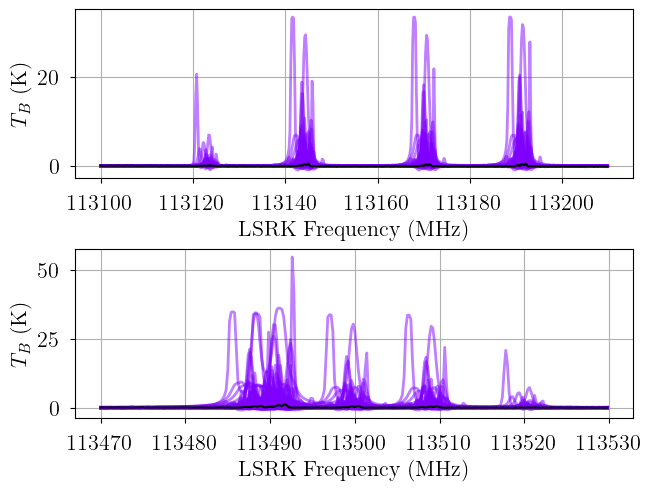

In [11]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

We can also generate a pair plot to inspect the prior distributions and their effect on deterministic quantities. The model has several attributes to access the various free parameters (`freeRVs`) and deterministic quantities (`deterministics`). Here we show the pair plot for the deterministic quantities derived from our prior distributions. The three red points correspond to the simulation parameters ("truths") for our three clouds.

baseline_freeRVs ['baseline_12CN-1_norm', 'baseline_12CN-2_norm']
baseline_deterministics []
cloud_freeRVs ['velocity_norm', 'log10_Tkin_norm', 'fwhm_nonthermal_norm', 'log10_N_norm']
cloud_deterministics ['velocity', 'log10_Tkin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'Tex', 'tau', 'tau_total', 'TR']
hyper_freeRVs ['fwhm_L_norm']
hyper_deterministics ['fwhm_L']


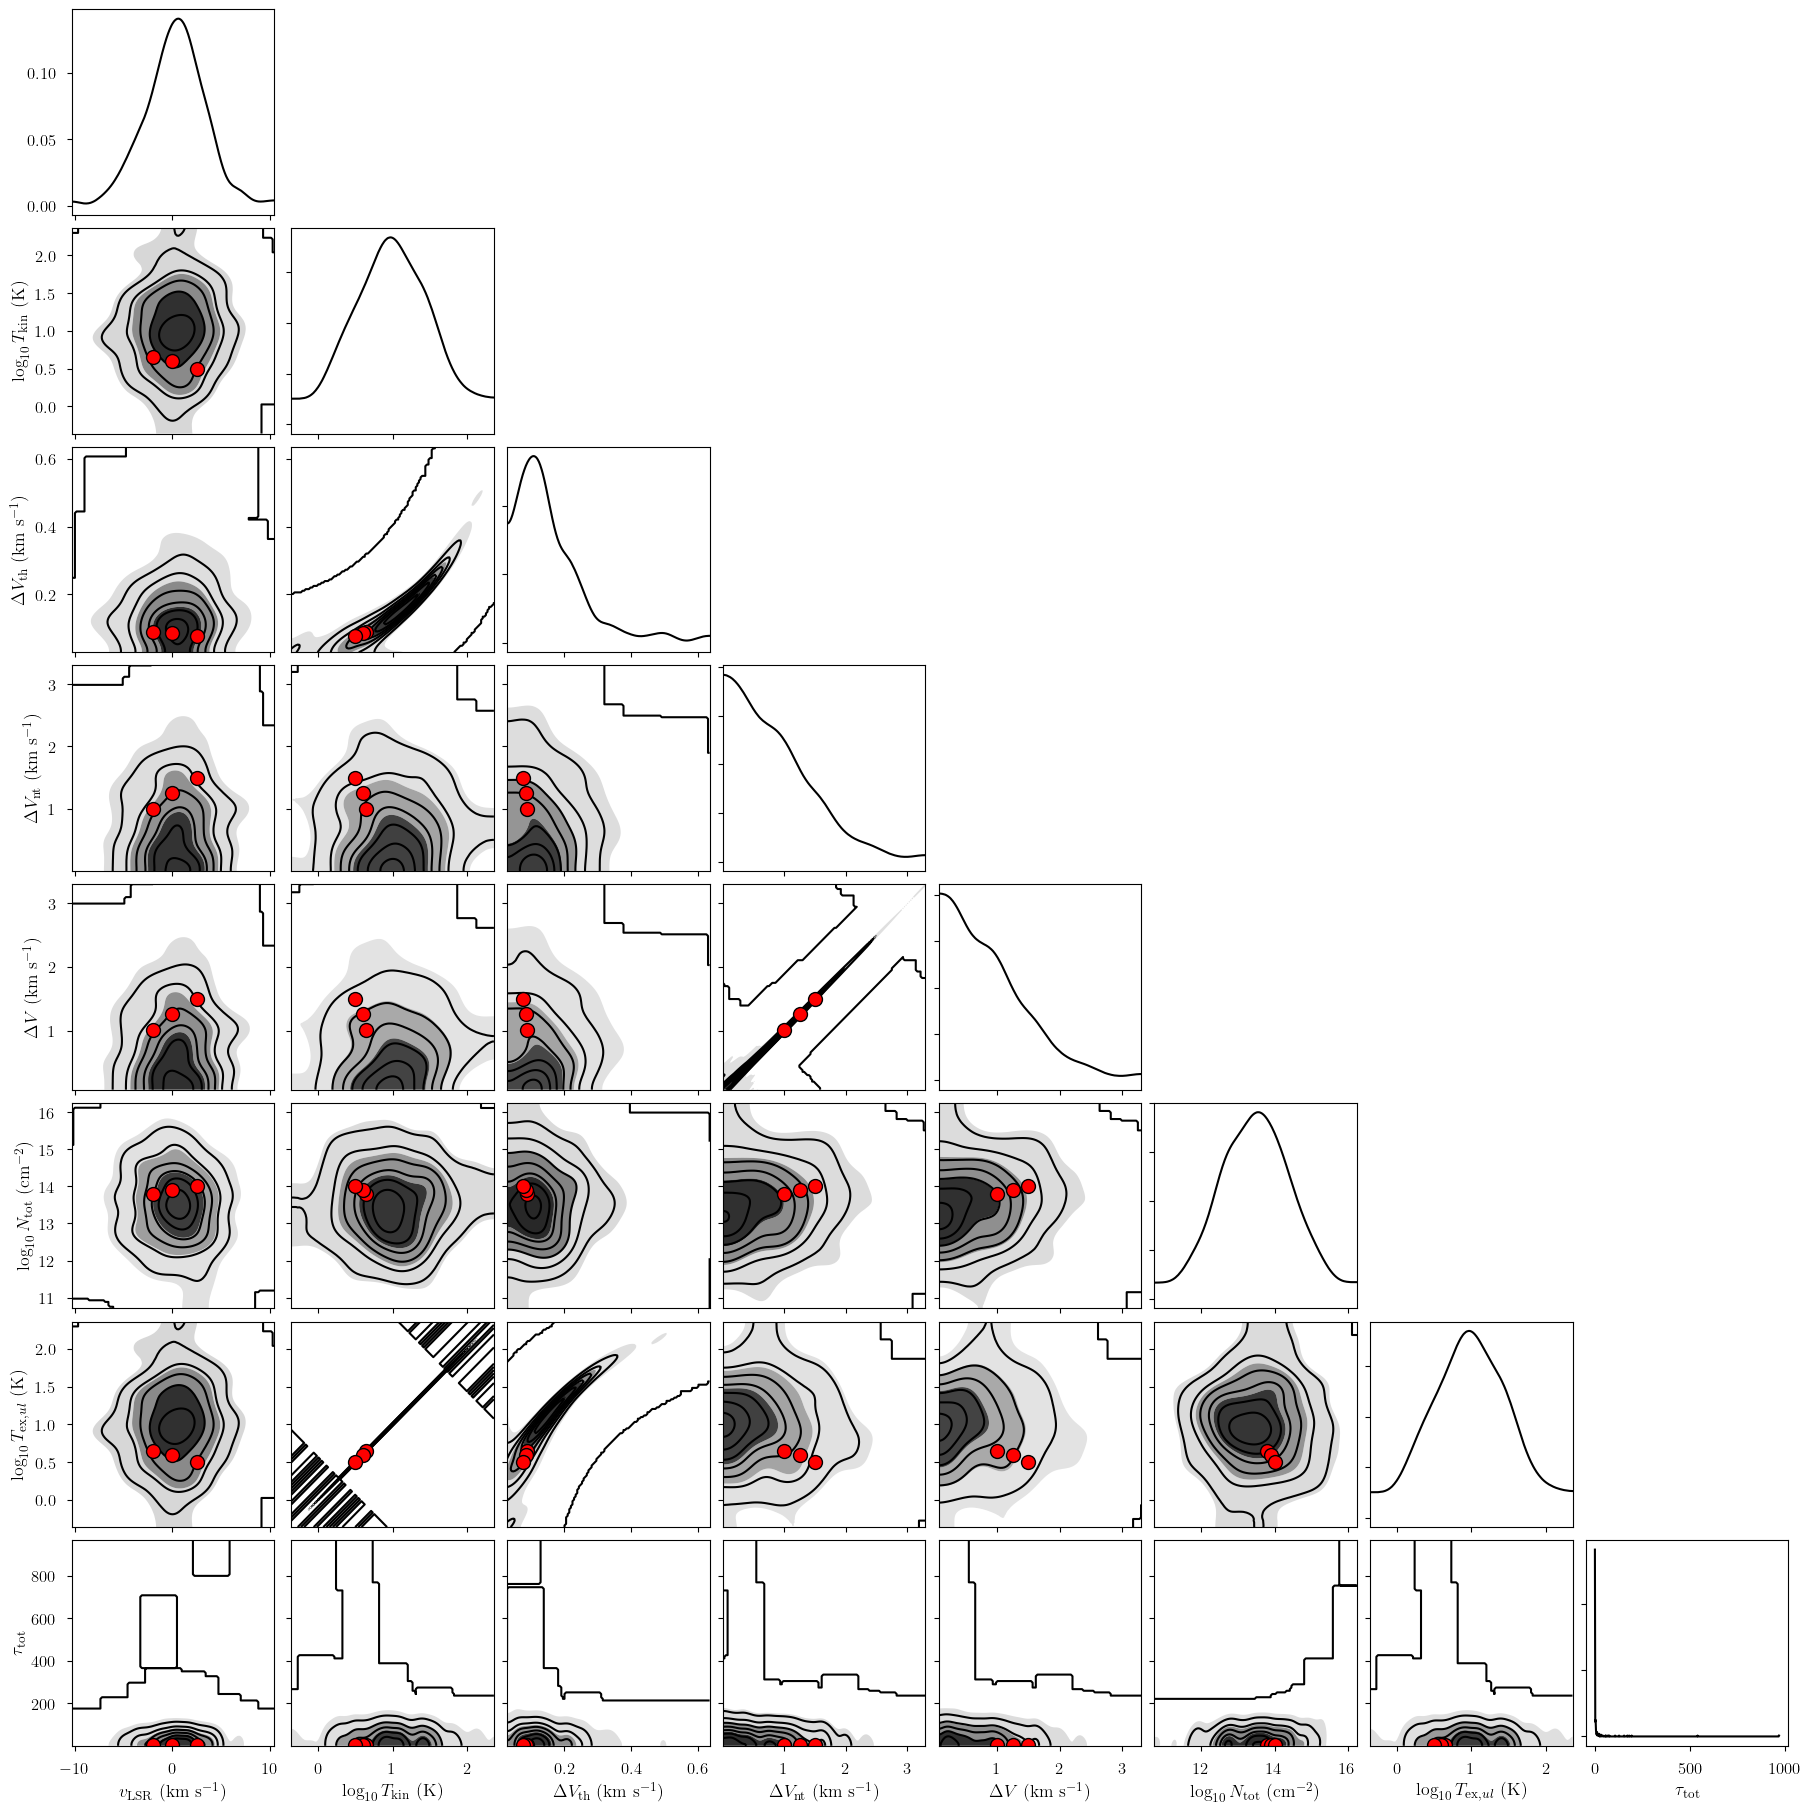

In [14]:
from bayes_spec.plots import plot_pair

# available parameter attributes:
print("baseline_freeRVs", model.baseline_freeRVs)
print("baseline_deterministics", model.baseline_deterministics)
print("cloud_freeRVs", model.cloud_freeRVs)
print("cloud_deterministics", model.cloud_deterministics)
print("hyper_freeRVs", model.hyper_freeRVs)
print("hyper_deterministics", model.hyper_deterministics)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [15]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5700
Interrupted at 5,699 [5%]: Average Loss = 4,430


Output()

Runtime: 0.94 minutes


In [16]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]              -0.000  0.015  -0.028    0.028      0.000    0.000   
velocity[1]               2.535  0.035   2.472    2.603      0.001    0.001   
velocity[2]              -1.981  0.009  -1.998   -1.964      0.000    0.000   
log10_Tkin[0]             0.597  0.002   0.592    0.601      0.000    0.000   
log10_Tkin[1]             0.497  0.002   0.493    0.502      0.000    0.000   
log10_Tkin[2]             0.648  0.003   0.643    0.654      0.000    0.000   
fwhm_thermal[0]           0.083  0.000   0.083    0.084      0.000    0.000   
fwhm_thermal[1]           0.074  0.000   0.074    0.075      0.000    0.000   
fwhm_thermal[2]           0.088  0.000   0.088    0.089      0.000    0.000   
fwhm_nonthermal[0]        1.336  0.036   1.273    1.405      0.001    0.001   
fwhm_nonthermal[1]        1.384  0.080   1.241    1.537      0.003    0.002   
fwhm_nonthermal[2]        1.001  0.022   0.961    1.040      0.001    0.001   
fwhm[0]                   1.338  0.036   1.275    1.408      0.001    0.001   
fwhm[1]                   1.386  0.080   1.243    1.539      0.003    0.002   
fwhm[2]                   1.005  0.022   0.965    1.043      0.001    0.001   
log10_N[0]               13.921  0.010  13.903   13.939      0.000    0.000   
log10_N[1]               14.020  0.025  13.979   14.072      0.001    0.001   
log10_N[2]               13.793  0.008  13.778   13.809      0.000    0.000   
log10_Tex_ul[0]           0.597  0.002   0.592    0.601      0.000    0.000   
log10_Tex_ul[1]           0.497  0.002   0.493    0.502      0.000    0.000   
log10_Tex_ul[2]           0.648  0.003   0.643    0.654      0.000    0.000   
tau_total[0]              3.474  0.083   3.321    3.629      0.003    0.002   
tau_total[1]              5.528  0.319   4.897    6.093      0.010    0.007   
tau_total[2]              2.282  0.047   2.197    2.366      0.002    0.001   
fwhm_L                    0.033  0.021   0.007    0.069      0.001    0.001   
baseline_12CN-1_norm[0]  -0.281  0.048  -0.364   -0.183      0.001    0.001   
baseline_12CN-1_norm[1]  -4.712  0.154  -4.992   -4.411      0.005    0.003   
baseline_12CN-1_norm[2]   3.953  0.717   2.608    5.294      0.025    0.017   
baseline_12CN-2_norm[0]  -0.349  0.065  -0.477   -0.236      0.002    0.001   
baseline_12CN-2_norm[1]  -1.815  0.214  -2.193   -1.379      0.007    0.005   
baseline_12CN-2_norm[2]   0.683  0.791  -0.753    2.113      0.025    0.018   

                         ess_bulk  ess_tail  r_hat  
velocity[0]                1038.0     855.0    NaN  
velocity[1]                 977.0     935.0    NaN  
velocity[2]                 998.0     838.0    NaN  
log10_Tkin[0]              1217.0     975.0    NaN  
log10_Tkin[1]               957.0    1023.0    NaN  
log10_Tkin[2]               892.0     837.0    NaN  
fwhm_thermal[0]            1217.0     975.0    NaN  
fwhm_thermal[1]             957.0    1023.0    NaN  
fwhm_thermal[2]             892.0     837.0    NaN  
fwhm_nonthermal[0]         1069.0     941.0    NaN  
fwhm_nonthermal[1]         1013.0     869.0    NaN  
fwhm_nonthermal[2]         1014.0     988.0    NaN  
fwhm[0]                    1069.0     941.0    NaN  
fwhm[1]                    1013.0     869.0    NaN  
fwhm[2]                    1014.0     988.0    NaN  
log10_N[0]                  802.0     992.0    NaN  
log10_N[1]                  946.0     885.0    NaN  
log10_N[2]                  833.0     921.0    NaN  
log10_Tex_ul[0]            1217.0     975.0    NaN  
log10_Tex_ul[1]             957.0    1023.0    NaN  
log10_Tex_ul[2]             892.0     837.0    NaN  
tau_total[0]                806.0    1024.0    NaN  
tau_total[1]                973.0     841.0    NaN  
tau_total[2]                928.0     952.0    NaN  
fwhm_L                      943.0     984.0    NaN  
baseline_12CN-1_norm[0]    1032.0     942.0    NaN  
baseline_12CN-1_norm[1]     956.0     973.0    NaN  
baseline_12CN-

Sampling: [12CN-1, 12CN-2]


Output()

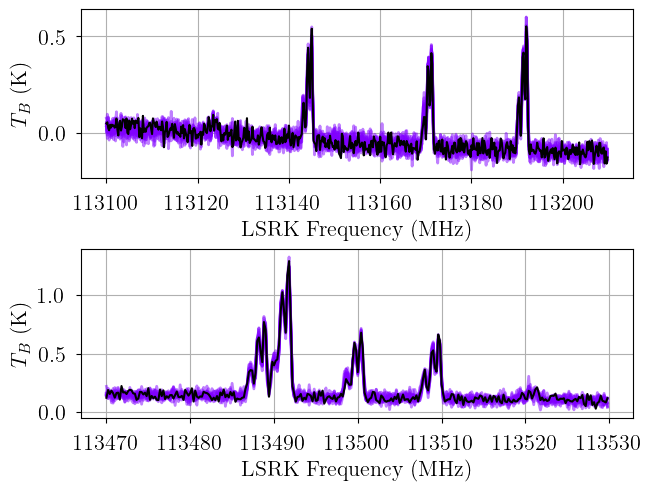

In [17]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [18]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5700
Interrupted at 5,699 [5%]: Average Loss = 4,430
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, log10_Tkin_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 83 seconds.


Adding log-likelihood to trace


Output()

There were 1 divergences in converged chains.
Runtime: 2.09 minutes


In [19]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [20]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]               0.014  0.016  -0.016    0.043      0.000    0.000   
velocity[1]               2.538  0.035   2.469    2.601      0.000    0.000   
velocity[2]              -1.991  0.011  -2.010   -1.971      0.000    0.000   
log10_Tkin[0]             0.597  0.006   0.586    0.609      0.000    0.000   
log10_Tkin[1]             0.496  0.005   0.486    0.506      0.000    0.000   
log10_Tkin[2]             0.652  0.008   0.637    0.667      0.000    0.000   
fwhm_thermal[0]           0.083  0.001   0.082    0.085      0.000    0.000   
fwhm_thermal[1]           0.074  0.000   0.073    0.075      0.000    0.000   
fwhm_thermal[2]           0.089  0.001   0.087    0.090      0.000    0.000   
fwhm_nonthermal[0]        1.324  0.044   1.241    1.408      0.001    0.000   
fwhm_nonthermal[1]        1.374  0.087   1.216    1.541      0.001    0.001   
fwhm_nonthermal[2]        0.998  0.026   0.949    1.049      0.000    0.000   
fwhm[0]                   1.327  0.044   1.244    1.411      0.001    0.000   
fwhm[1]                   1.376  0.087   1.212    1.536      0.001    0.001   
fwhm[2]                   1.002  0.026   0.953    1.053      0.000    0.000   
log10_N[0]               13.920  0.026  13.873   13.968      0.000    0.000   
log10_N[1]               14.017  0.062  13.903   14.135      0.001    0.001   
log10_N[2]               13.796  0.022  13.755   13.839      0.000    0.000   
log10_Tex_ul[0]           0.597  0.006   0.586    0.609      0.000    0.000   
log10_Tex_ul[1]           0.496  0.005   0.486    0.506      0.000    0.000   
log10_Tex_ul[2]           0.652  0.008   0.637    0.667      0.000    0.000   
tau_total[0]              3.468  0.252   3.018    3.961      0.003    0.003   
tau_total[1]              5.557  0.852   4.029    7.198      0.011    0.009   
tau_total[2]              2.283  0.160   1.981    2.582      0.002    0.002   
fwhm_L                    0.027  0.024   0.000    0.071      0.000    0.000   
baseline_12CN-1_norm[0]  -0.266  0.052  -0.365   -0.170      0.001    0.001   
baseline_12CN-1_norm[1]  -4.757  0.148  -5.050   -4.498      0.001    0.002   
baseline_12CN-1_norm[2]   3.969  0.787   2.484    5.428      0.008    0.008   
baseline_12CN-2_norm[0]  -0.334  0.073  -0.470   -0.196      0.001    0.001   
baseline_12CN-2_norm[1]  -1.782  0.200  -2.156   -1.410      0.002    0.003   
baseline_12CN-2_norm[2]   0.639  0.892  -1.059    2.264      0.009    0.010   

                         ess_bulk  ess_tail  r_hat  
velocity[0]               10077.0    6375.0    1.0  
velocity[1]               10823.0    6099.0    1.0  
velocity[2]                8479.0    6210.0    1.0  
log10_Tkin[0]              7211.0    5724.0    1.0  
log10_Tkin[1]              6066.0    5549.0    1.0  
log10_Tkin[2]              6155.0    5886.0    1.0  
fwhm_thermal[0]            7211.0    5724.0    1.0  
fwhm_thermal[1]            6066.0    5549.0    1.0  
fwhm_thermal[2]            6155.0    5886.0    1.0  
fwhm_nonthermal[0]         6956.0    6195.0    1.0  
fwhm_nonthermal[1]         7684.0    6204.0    1.0  
fwhm_nonthermal[2]         8330.0    6531.0    1.0  
fwhm[0]                    6954.0    6195.0    1.0  
fwhm[1]                    7682.0    6204.0    1.0  
fwhm[2]                    8323.0    6531.0    1.0  
log10_N[0]                 7432.0    6246.0    1.0  
log10_N[1]                 6289.0    5892.0    1.0  
log10_N[2]                 6134.0    5934.0    1.0  
log10_Tex_ul[0]            7211.0    5724.0    1.0  
log10_Tex_ul[1]            6066.0    5549.0    1.0  
log10_Tex_ul[2]            6155.0    5886.0    1.0  
tau_total[0]               7376.0    6121.0    1.0  
tau_total[1]               6248.0    5788.0    1.0  
tau_total[2]               6085.0    5817.0    1.0  
fwhm_L                     6680.0    3936.0    1.0  
baseline_12CN-1_norm[0]    8375.0    6438.0    1.0  
baseline_12CN-1_norm[1]   14607.0    6054.0    1.0  
baseline_12CN-

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [12CN-1, 12CN-2]


Output()

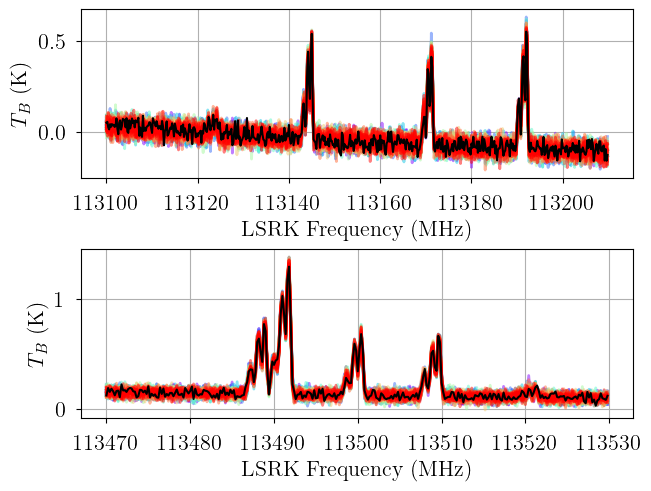

In [21]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

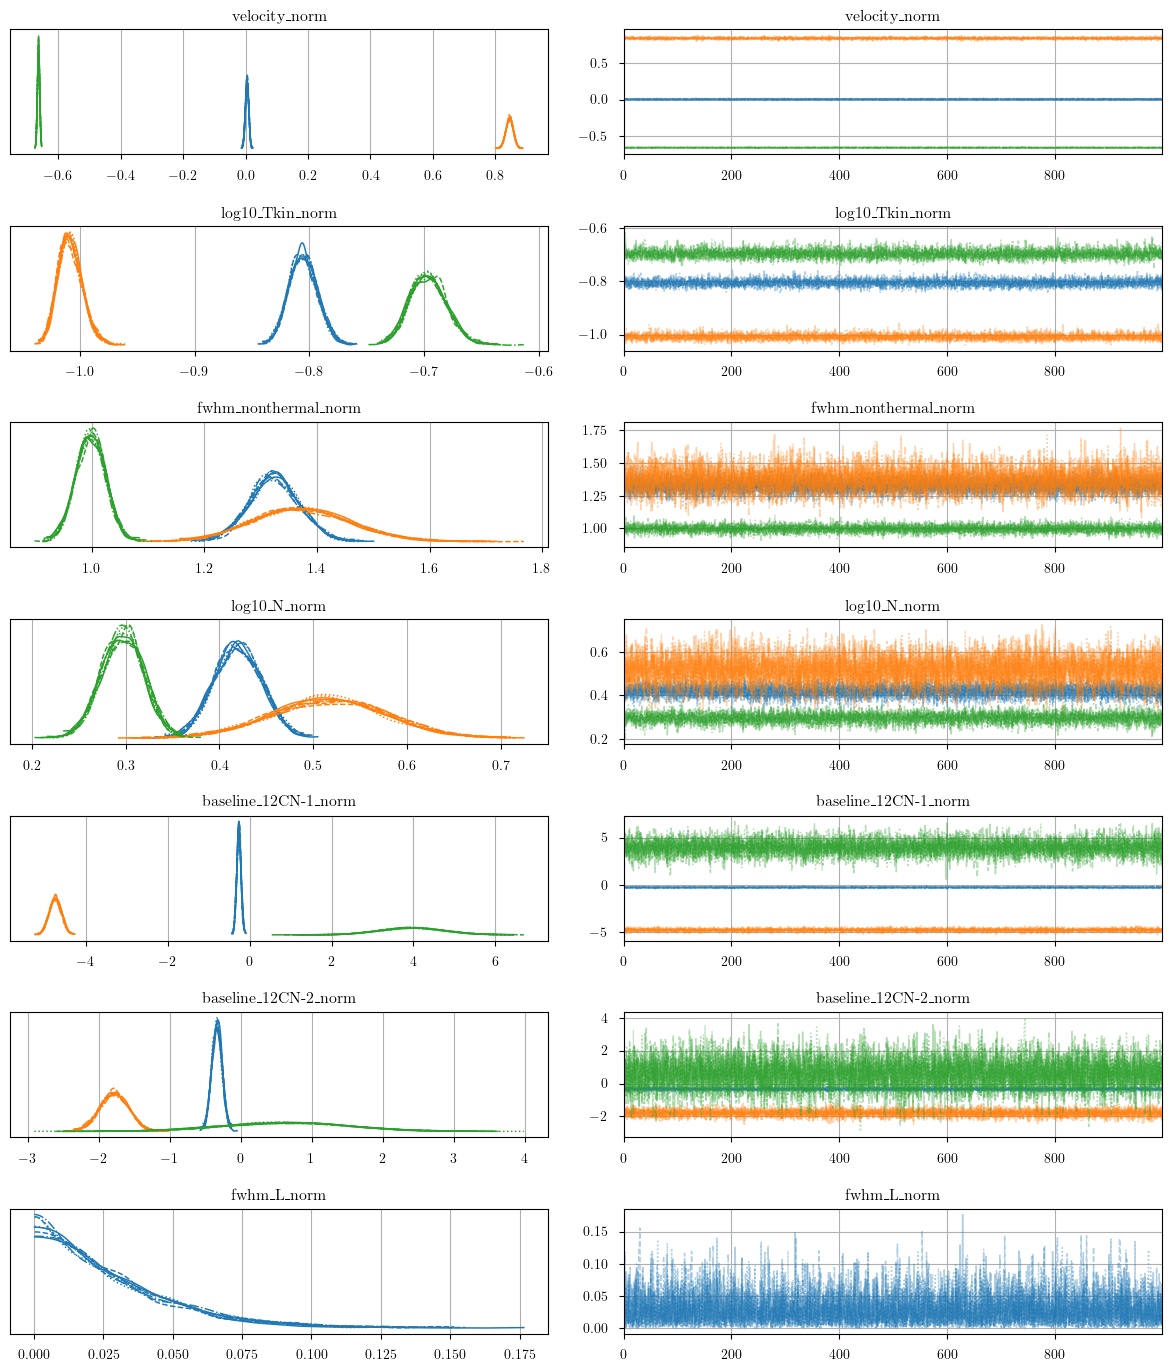

In [24]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

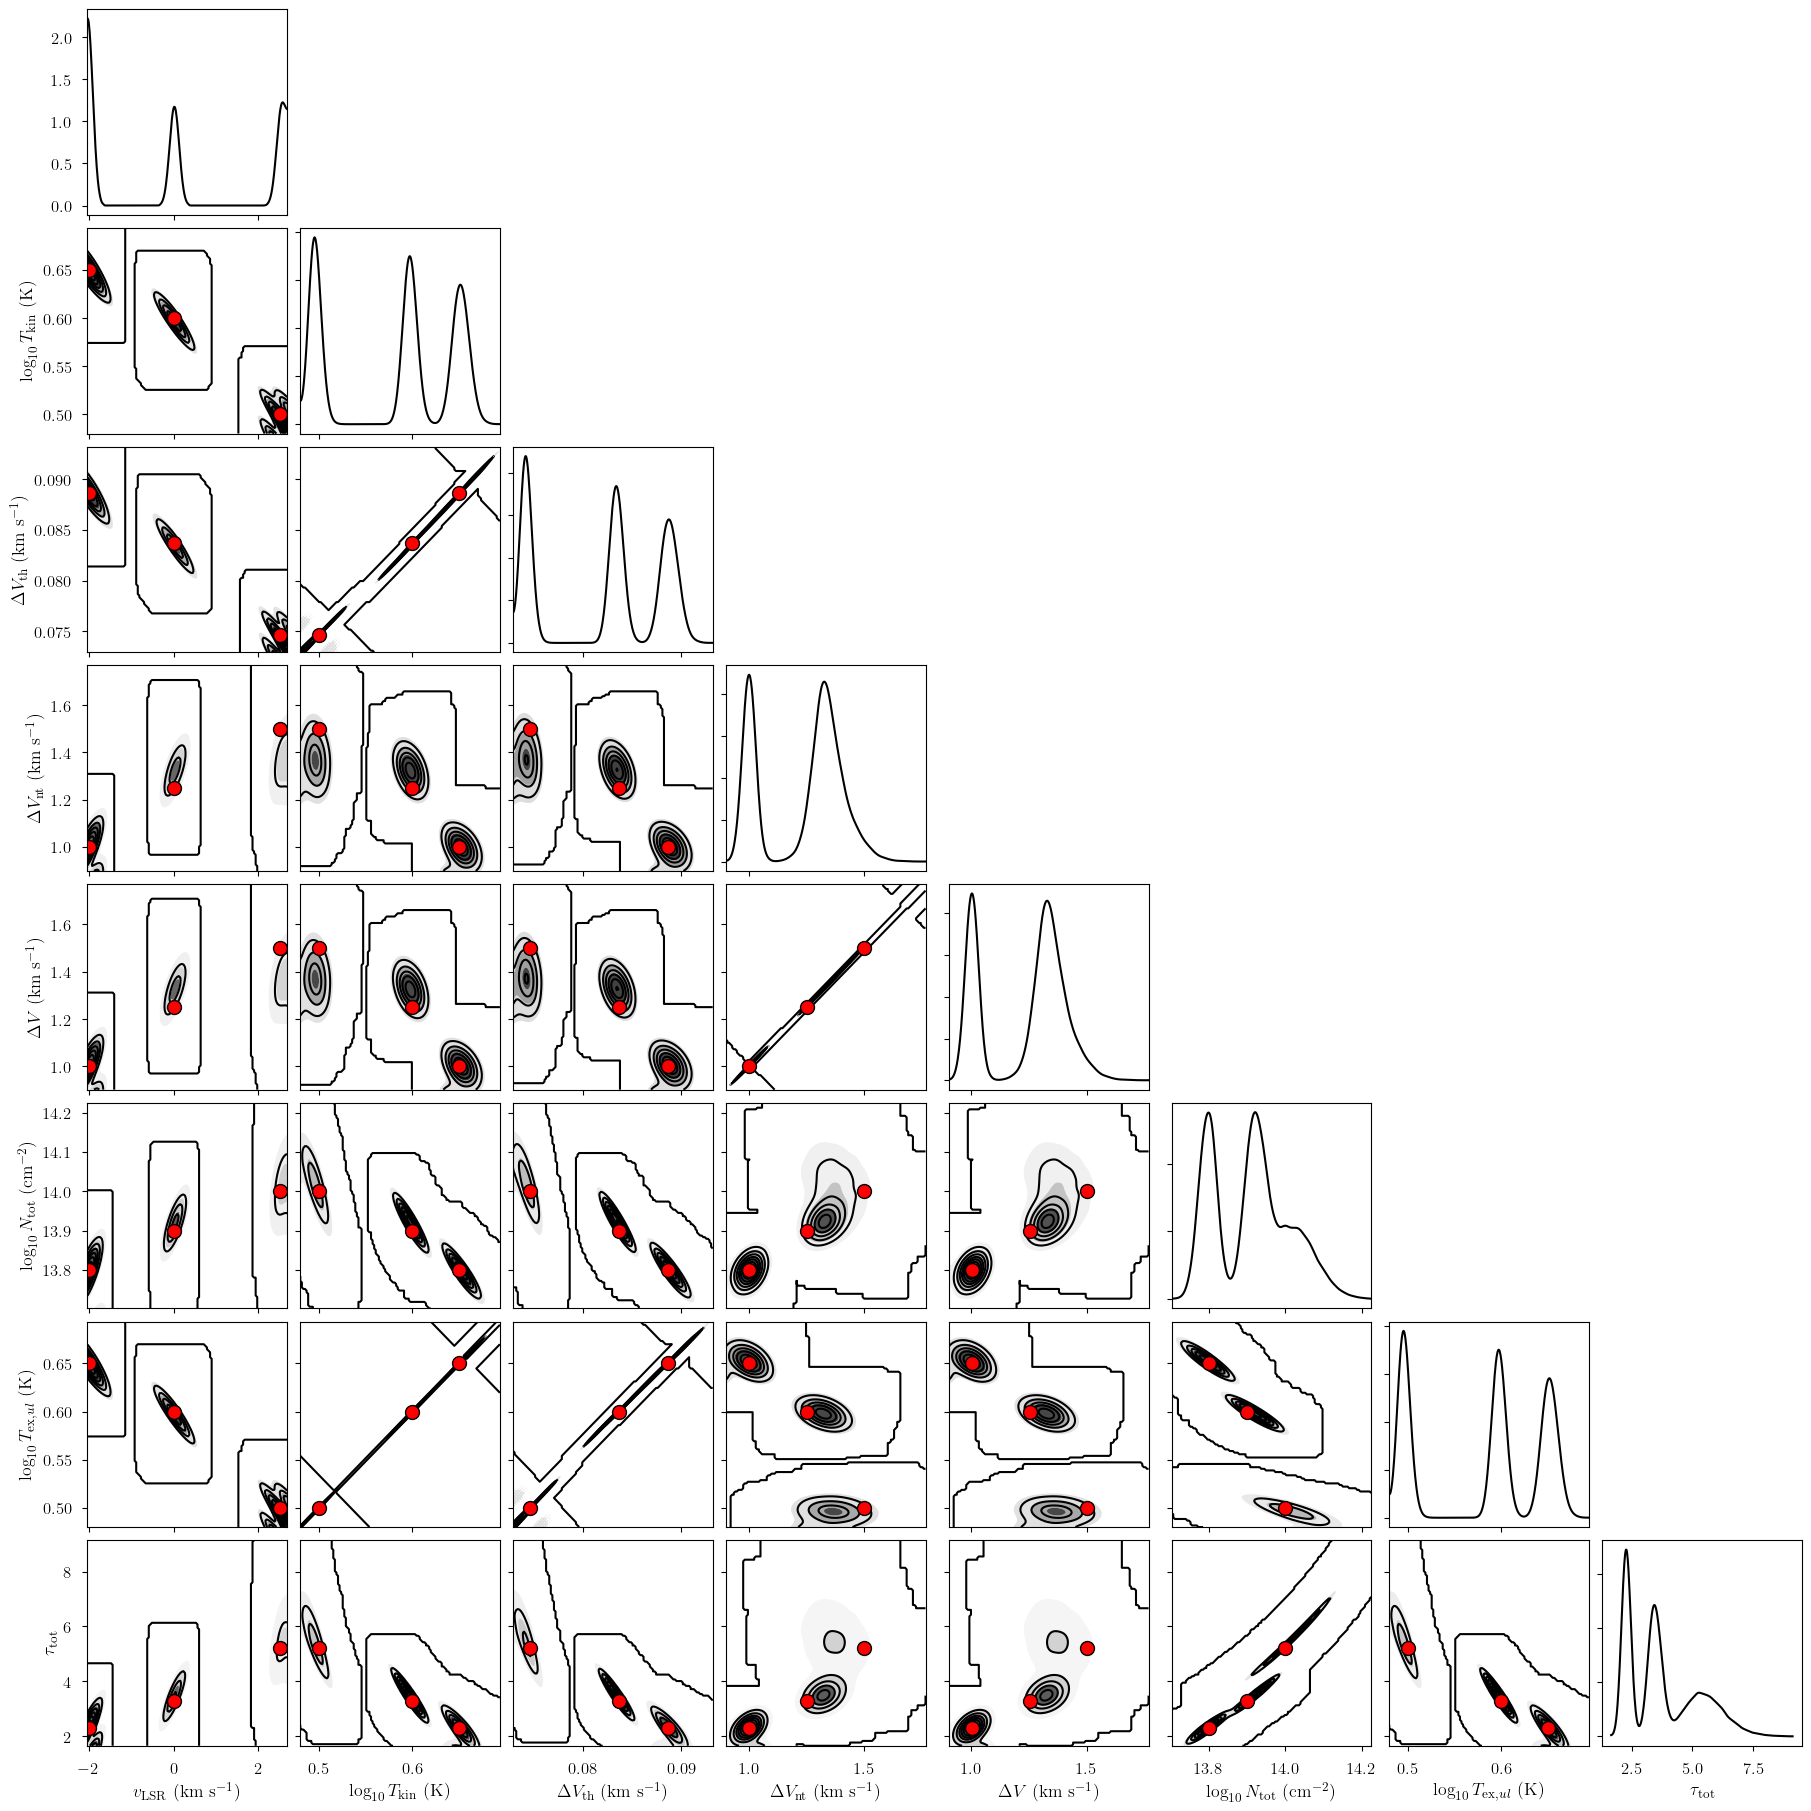

In [25]:
from bayes_spec.plots import plot_pair

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the transition and state dependent parameters for clarity) along with the model hyper-parameters.

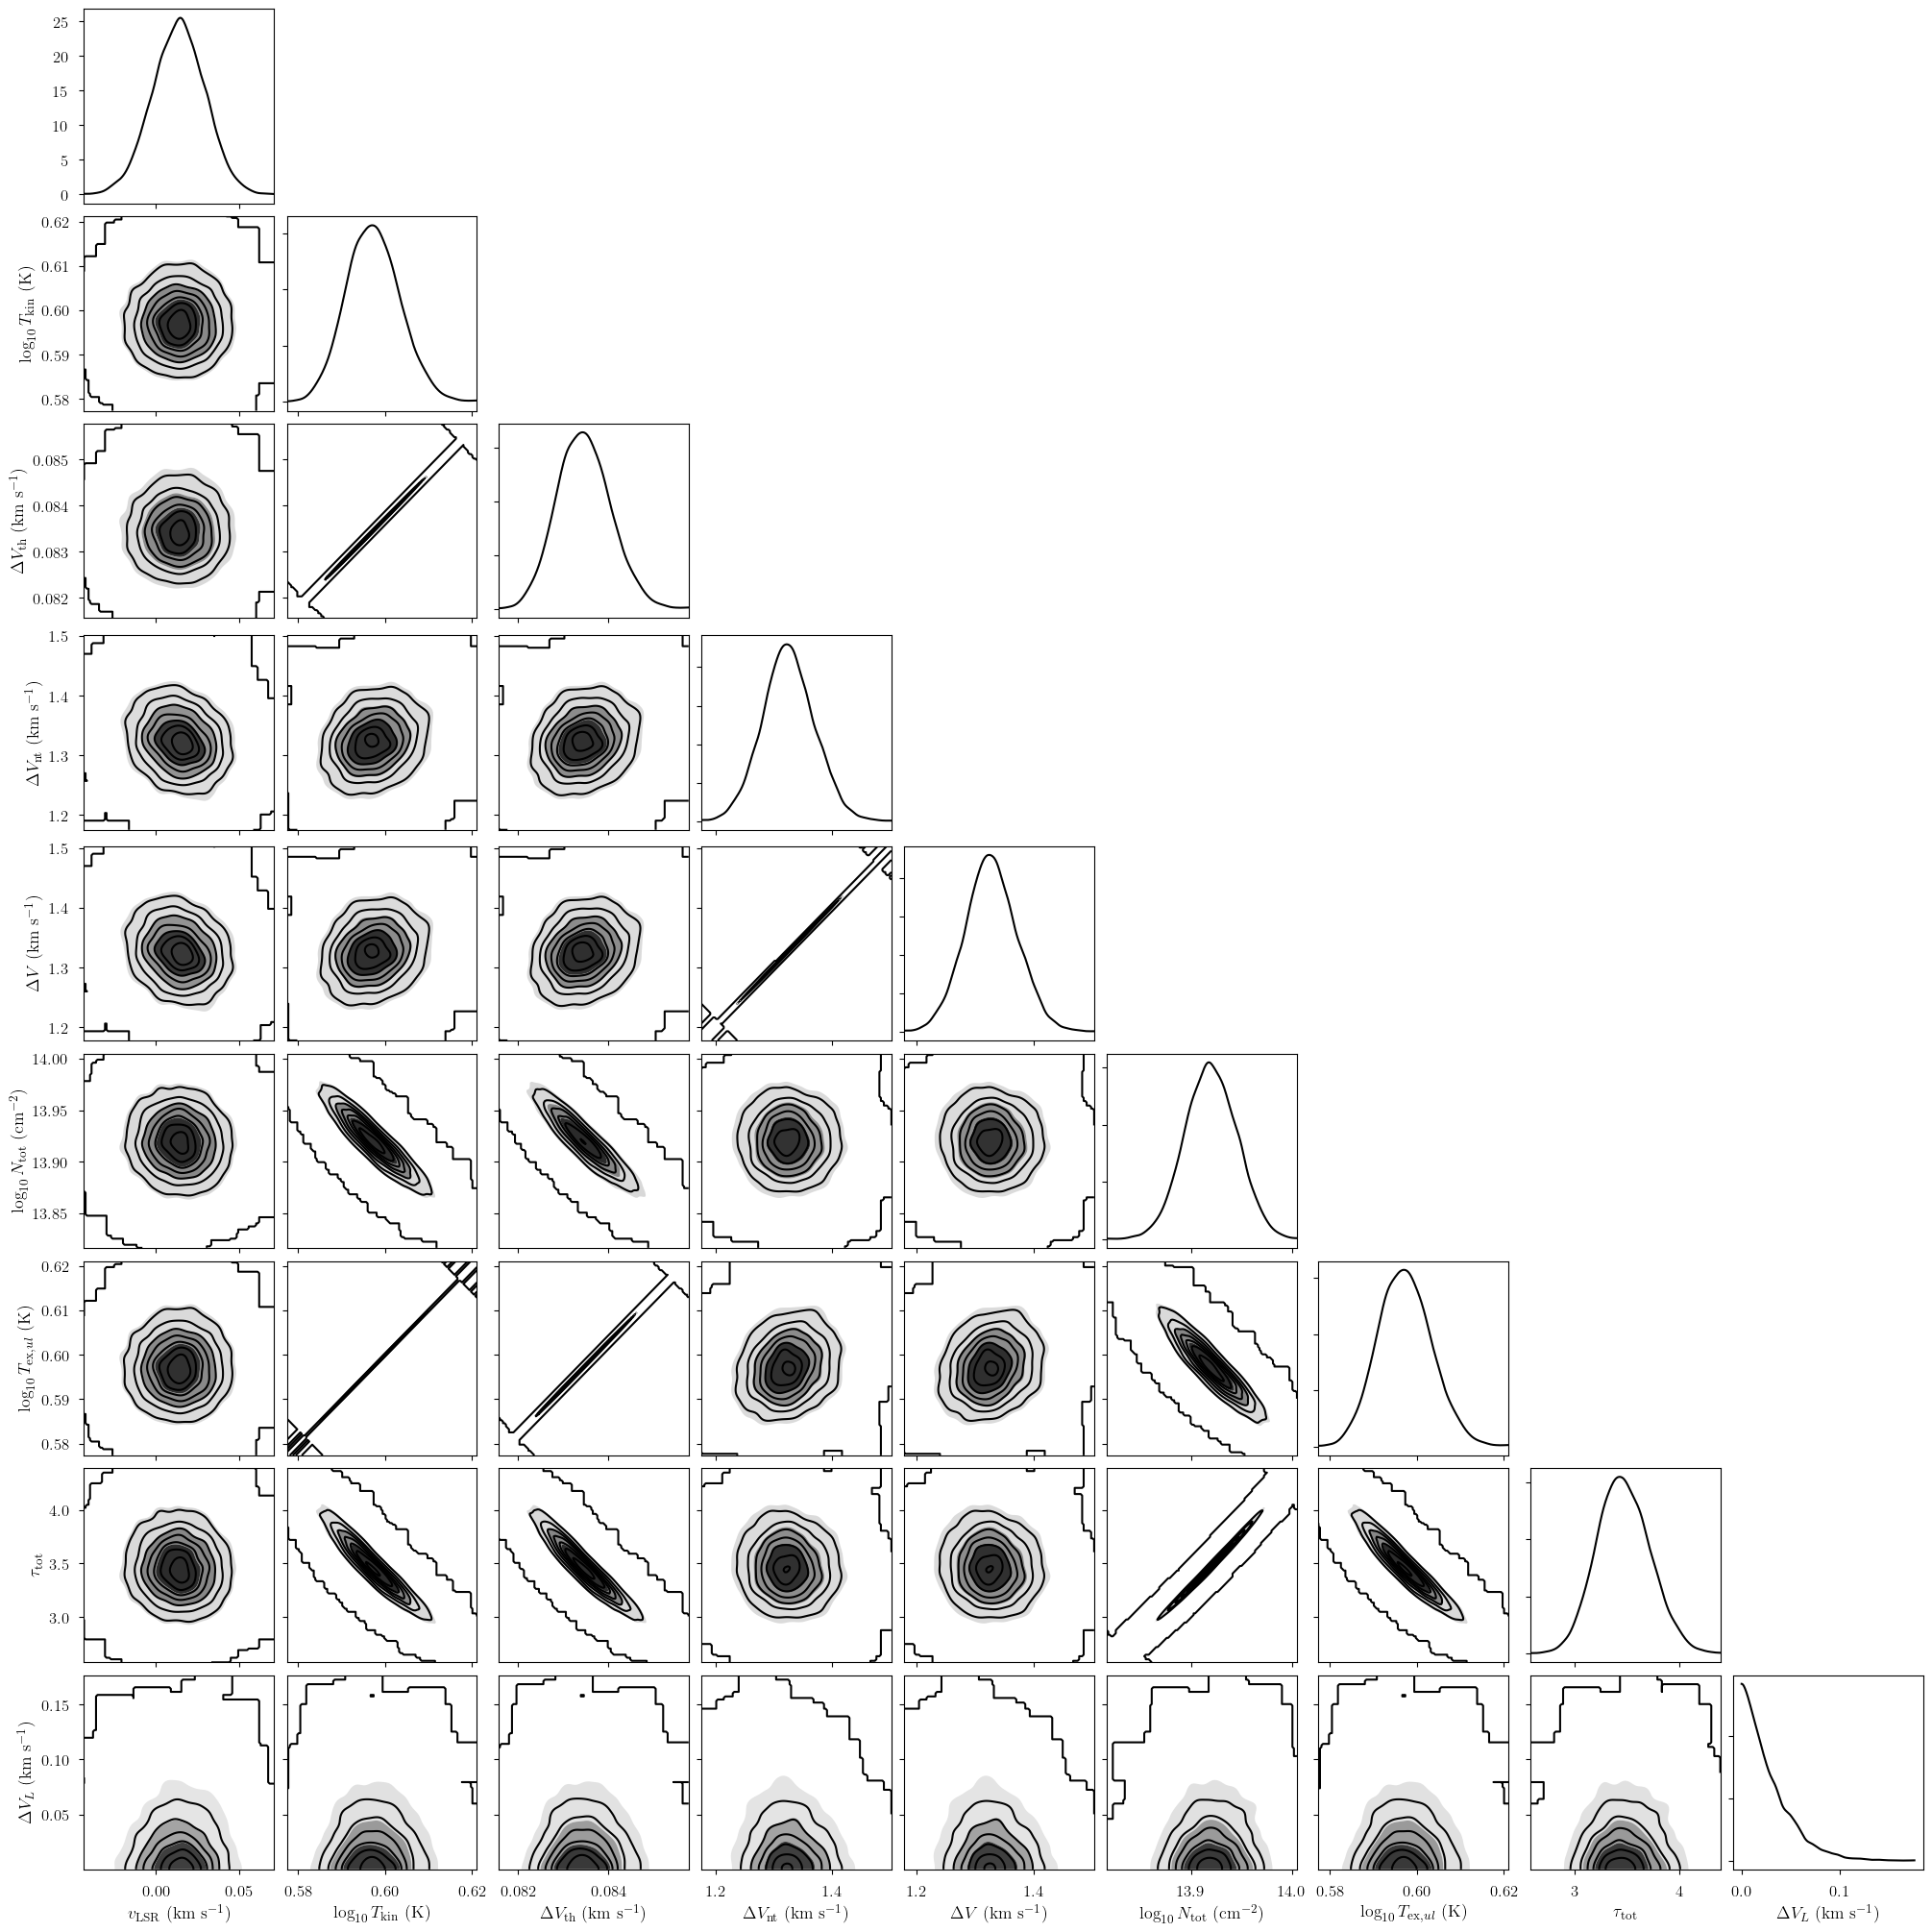

In [27]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
)

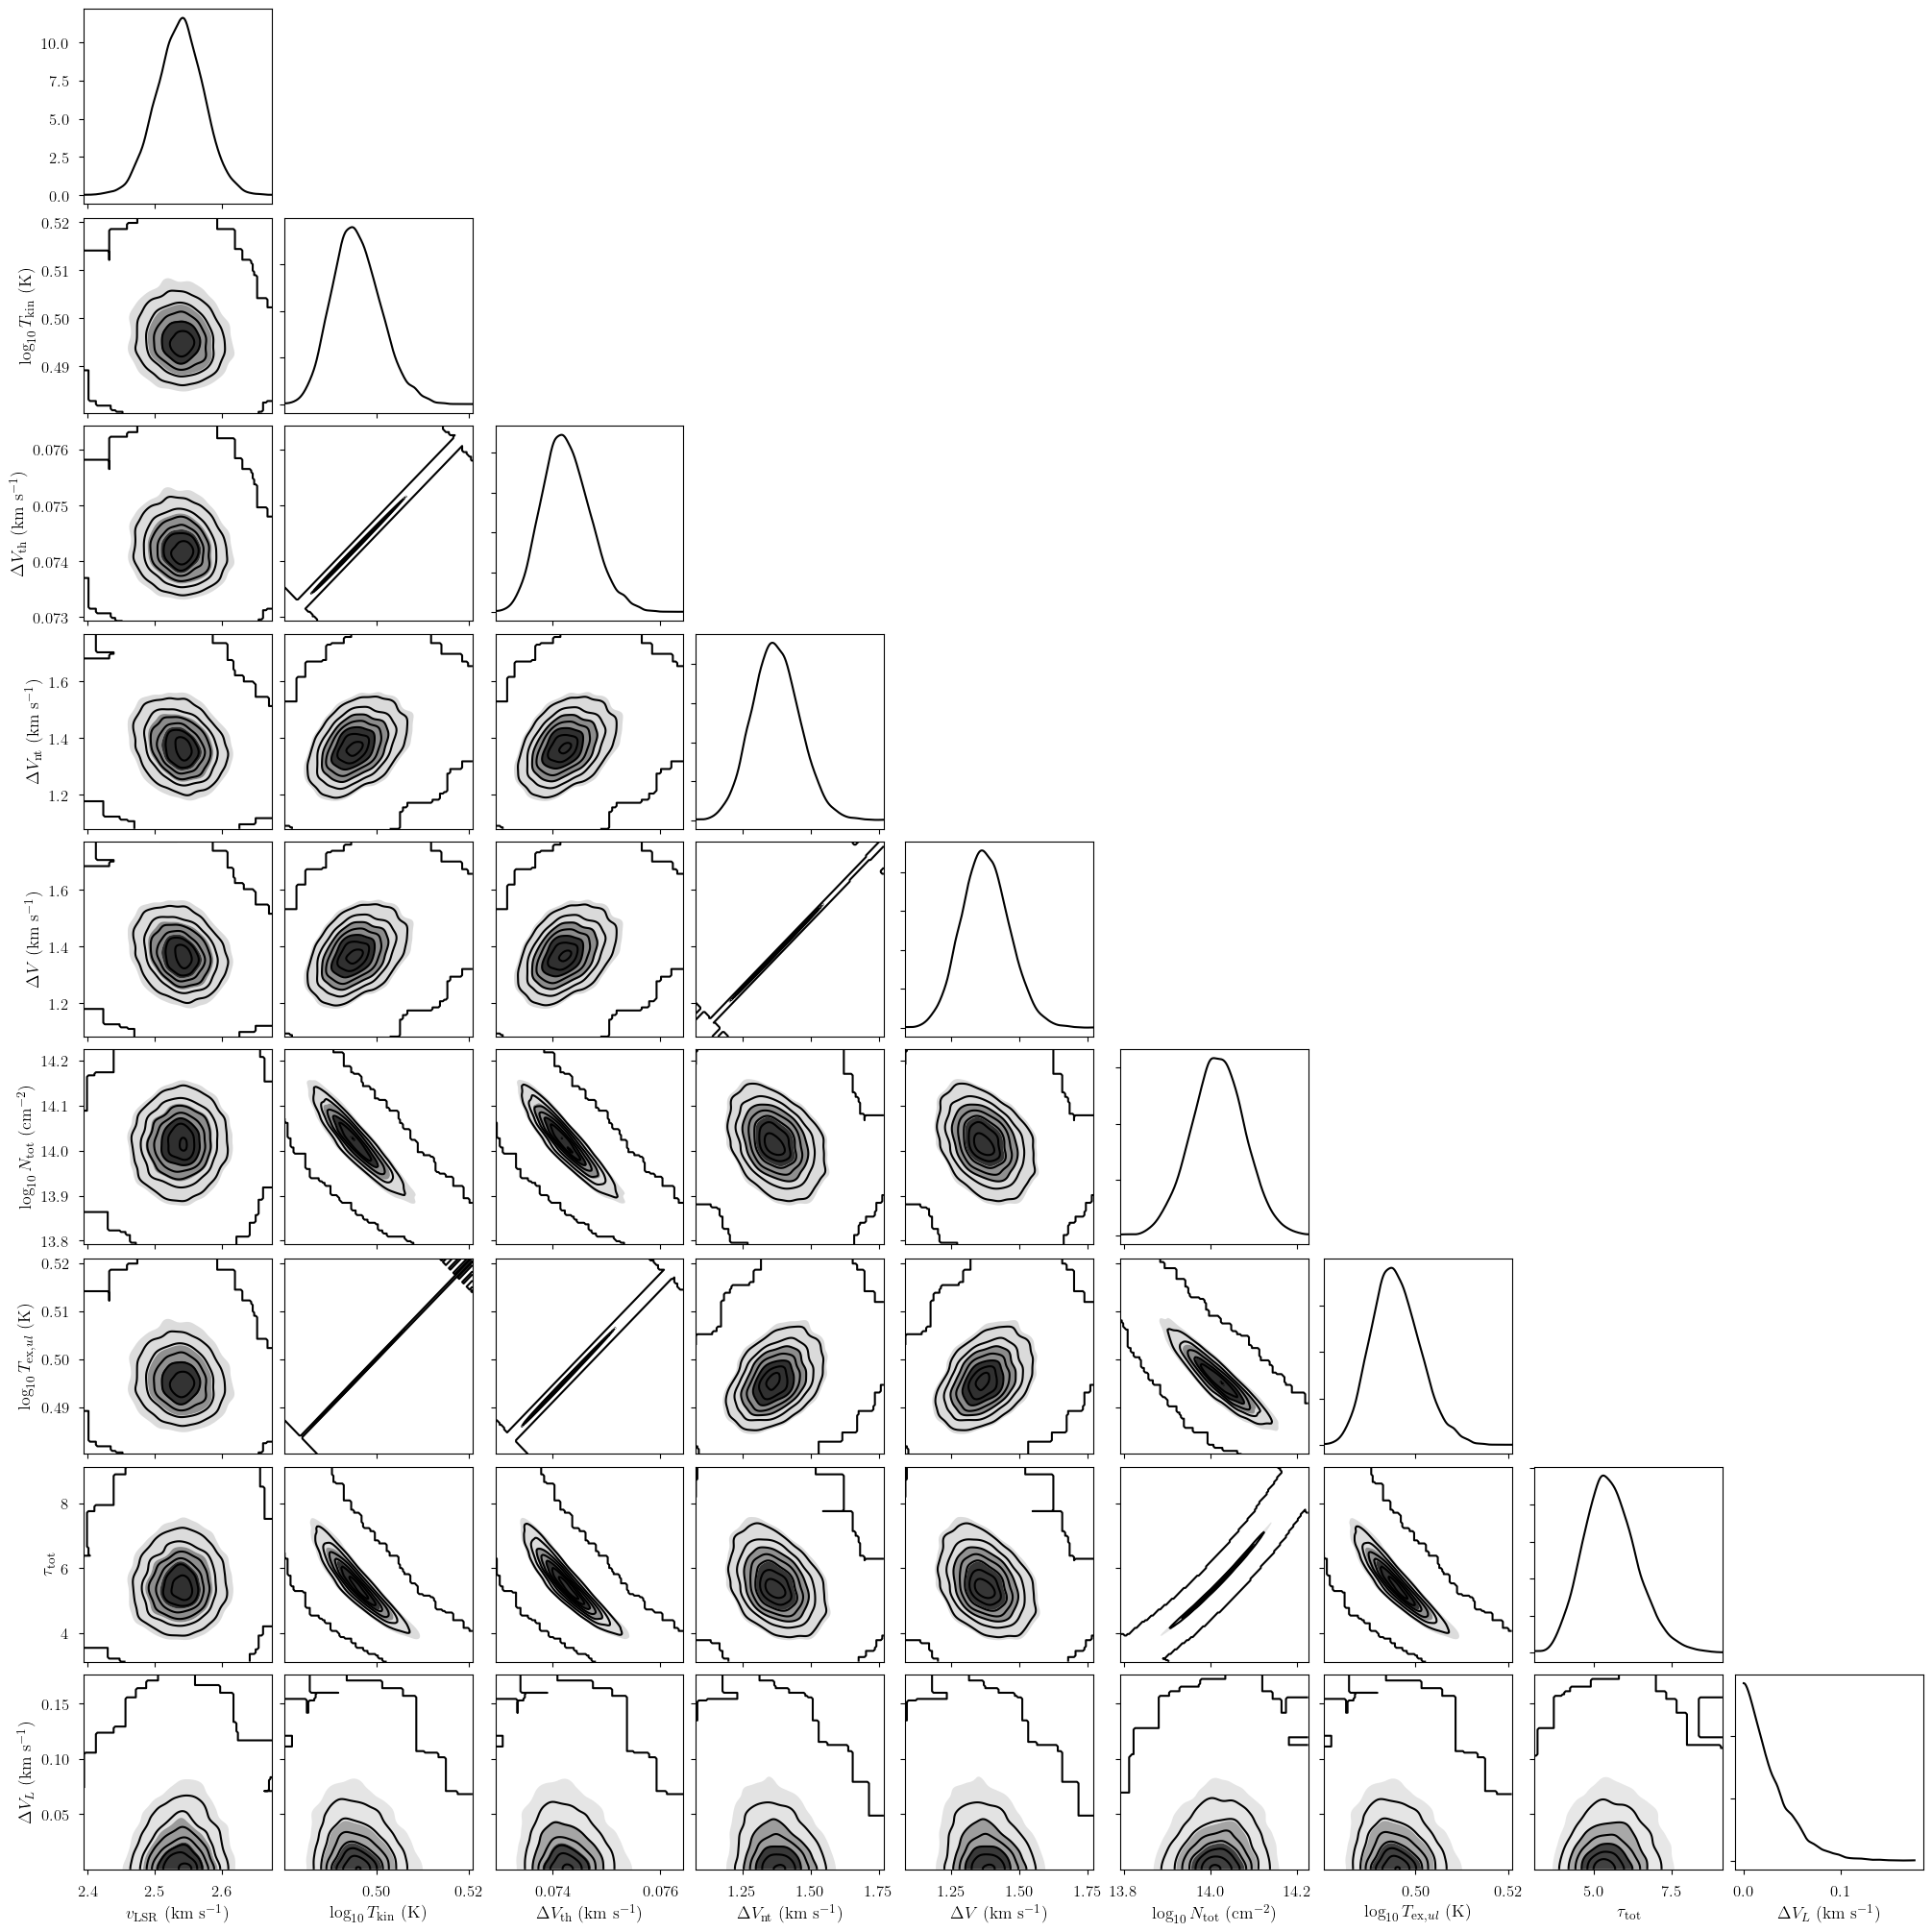

In [28]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
)

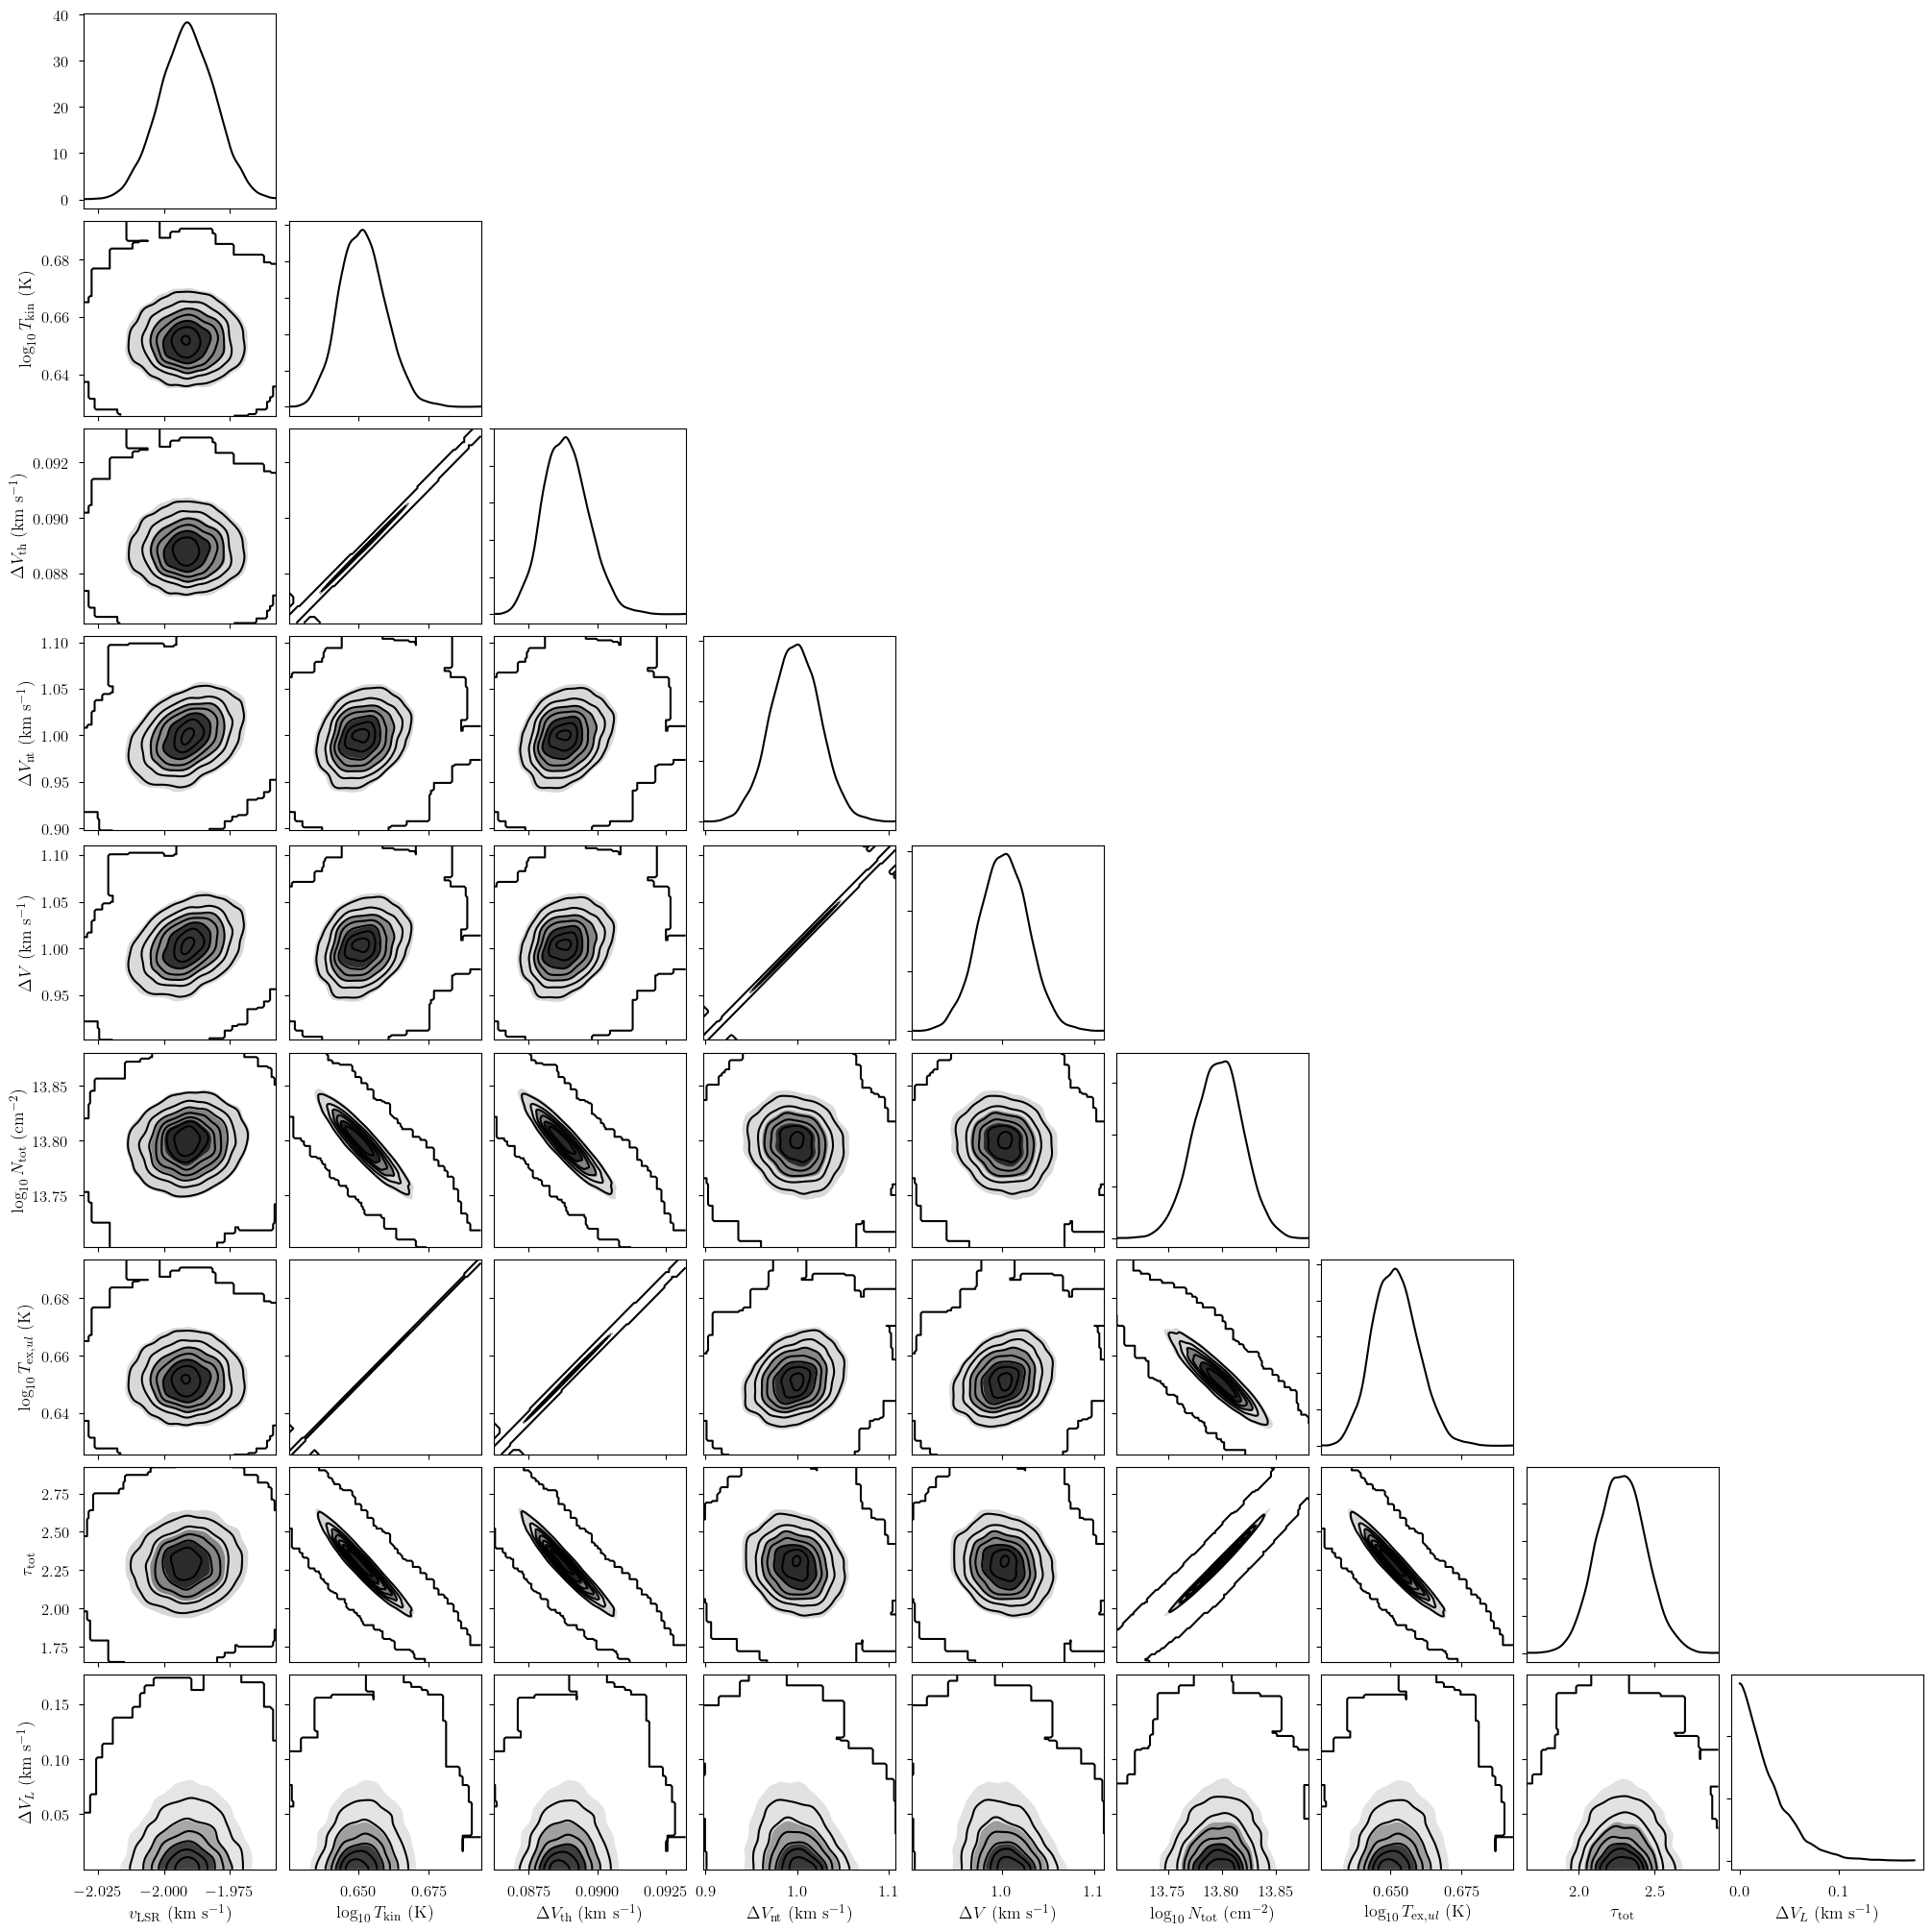

In [29]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [30]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -3443.8701019859545


mean     sd  hdi_16%  hdi_84%
velocity[0]               0.014  0.016    0.000    0.032
velocity[1]               2.538  0.035    2.503    2.572
velocity[2]              -1.991  0.011   -2.001   -1.980
log10_Tkin[0]             0.597  0.006    0.591    0.603
log10_Tkin[1]             0.496  0.005    0.490    0.501
log10_Tkin[2]             0.652  0.008    0.643    0.658
fwhm_thermal[0]           0.083  0.001    0.083    0.084
fwhm_thermal[1]           0.074  0.000    0.074    0.075
fwhm_thermal[2]           0.089  0.001    0.088    0.090
fwhm_nonthermal[0]        1.324  0.044    1.279    1.367
fwhm_nonthermal[1]        1.374  0.087    1.282    1.454
fwhm_nonthermal[2]        0.998  0.026    0.971    1.023
fwhm[0]                   1.327  0.044    1.281    1.368
fwhm[1]                   1.376  0.087    1.284    1.456
fwhm[2]                   1.002  0.026    0.975    1.027
log10_N[0]               13.920  0.026   13.894   13.945
log10_N[1]               14.017  0.062   13.954   14.076
log10_N[2]               13.796  0.022   13.773   13.818
log10_Tex_ul[0]           0.597  0.006    0.591    0.603
log10_Tex_ul[1]           0.496  0.005    0.490    0.501
log10_Tex_ul[2]           0.652  0.008    0.643    0.658
Tex[113123.3687, 0]       3.957  0.056    3.901    4.012
Tex[113123.3687, 1]       3.133  0.038    3.092    3.167
Tex[113123.3687, 2]       4.486  0.083    4.392    4.554
Tex[113144.19, 0]         3.957  0.056    3.901    4.012
Tex[113144.19, 1]         3.133  0.038    3.092    3.167
Tex[113144.19, 2]         4.486  0.083    4.392    4.554
Tex[113170.535, 0]        3.957  0.056    3.901    4.012
Tex[113170.535, 1]        3.133  0.038    3.092    3.167
Tex[113170.535, 2]        4.486  0.083    4.392    4.554
Tex[113191.325, 0]        3.957  0.056    3.901    4.012
Tex[113191.325, 1]        3.133  0.038    3.092    3.167
Tex[113191.325, 2]        4.486  0.083    4.392    4.554
Tex[113488.142, 0]        3.957  0.056    3.901    4.012
Tex[113488.142, 1]        3.133  0.038    3.092    3.167
Tex[113488.142, 2]        4.486  0.083    4.392    4.554
Tex[113490.985, 0]        3.957  0.056    3.901    4.012
Tex[113490.985, 1]        3.133  0.038    3.092    3.167
Tex[113490.985, 2]        4.486  0.083    4.392    4.554
Tex[113499.643, 0]        3.957  0.056    3.901    4.012
Tex[113499.643, 1]        3.133  0.038    3.092    3.167
Tex[113499.643, 2]        4.486  0.083    4.392    4.554
Tex[113508.934, 0]        3.957  0.056    3.901    4.012
Tex[113508.934, 1]        3.133  0.038    3.092    3.167
Tex[113508.934, 2]        4.486  0.083    4.392    4.554
Tex[113520.4215, 0]       3.957  0.056    3.901    4.012
Tex[113520.4215, 1]       3.133  0.038    3.092    3.167
Tex[113520.4215, 2]       4.486  0.083    4.392    4.554
tau[113123.3687, 0]       0.042  0.003    0.039    0.045
tau[113123.3687, 1]       0.067  0.010    0.056    0.076
tau[113123.3687, 2]       0.028  0.002    0.025    0.029
tau[113144.19, 0]         0.342  0.025    0.316    0.365
tau[113144.19, 1]         0.549  0.084    0.456    0.619
tau[113144.19, 2]         0.225  0.016    0.208    0.240
tau[113170.535, 0]        0.334  0.024    0.308    0.356
tau[113170.535, 1]        0.536  0.082    0.445    0.604
tau[113170.535, 2]        0.220  0.015    0.203    0.234
tau[113191.325, 0]        0.434  0.032    0.400    0.463
tau[113191.325, 1]        0.696  0.107    0.578    0.785
tau[113191.325, 2]        0.286  0.020    0.264    0.304
tau[113488.142, 0]        0.436  0.032    0.402    0.465
tau[113488.142, 1]        0.698  0.107    0.580    0.787
tau[113488.142, 2]        0.287  0.020    0.265    0.305
tau[113490.985, 0]        1.158  0.084    1.067    1.234
tau[113490.985, 1]        1.855  0.284    1.542    2.092
tau[113490.985, 2]        0.762  0.053    0.704    0.810
tau[113499.643, 0]        0.344  0.025    0.317    0.367
tau[113499.643, 1]        0.551  0.084    0.458    0.621
tau[113499.643, 2]        0.226  0.016    0.209    0.241
tau[113508.934, 0]        0.336  0.02